## CMPE/CISC 452 NLP Text Classification

By: Liam, Hayden, Taylor, Andrew

In [1]:
# Data Visualization
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


In [2]:
# Preprocessing Imports
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn.preprocessing import LabelEncoder
# from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sealgram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Tokenizing & Padding Imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import pickle

In [4]:
# For Building the model imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import keras.backend as K

In [5]:
# Bidirectional LSTM Using NN
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

In [6]:
def load_datasets():
    # Load Mobi Tweet dataset
    mobi_tweets = pd.read_csv('dataset/Twitter_Data.csv')
    
    # Load Apple Tweet dataset
    apple_tweets = pd.read_csv('dataset/apple-twitter-sentiment-texts.csv')
    apple_tweets = apple_tweets.rename(columns={'text': 'clean_text', 'sentiment': 'category'})
    apple_tweets['category'] = apple_tweets['category'].map({-1: -1.0, 0: 0.0, 1: 1.0})
    
    # Load Airplane Tweet dataset
    airplane_tweets = pd.read_csv('dataset/Tweets.csv')
    airplane_tweets = airplane_tweets.rename(columns={'text': 'clean_text', 'airline_sentiment': 'category'})
    airplane_tweets['category'] = airplane_tweets['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive': 1.0})
    airplane_tweets = airplane_tweets[['category', 'clean_text']]
    
    # Combine datasets
    combined_tweets = pd.concat([mobi_tweets, apple_tweets, airplane_tweets], ignore_index=True)
    
    # Check for missing values
    print("Number of missing values in combined dataset:\n", combined_tweets.isnull().sum())
    
    # Drop missing rows
    combined_tweets.dropna(axis=0, inplace=True)
    
    # Print the shape of the dataset
    print("Shape of the combined dataset:", combined_tweets.shape)
    
    # Map tweet categories
    combined_tweets['category'] = combined_tweets['category'].map({-1.0: 'Negative', 0.0: 'Neutral', 1.0: 'Positive'})
    
    # Output first five rows
    print("First five rows of the combined dataset:\n", combined_tweets.head())
    
    # Return the combined Data Frame
    return combined_tweets
   

In [7]:
def visualize_Data (df):
    """
    Visualizes the distribution of sentiments in the provided DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing tweet data.
    """
    
    # Grouping by 'category' and counting occurrences
    sentiment_counts = df['category'].value_counts()

    # Plotting the counts as a bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    
    # Setting plot labels and title
    plt.xlabel('Category')
    plt.ylabel('Number of Tweets')
    plt.title('Distribution of Sentiments in Tweet Data')
    plt.show()

In [8]:
def tweet_to_words(tweet):
    """
    Converts the text from a tweet into a list of words for further use.

    Parameters:
    tweet: String that forms a tweet to be converted into seperate words.
    """

    # Convert the tweet to lowercase
    text = tweet.lower()
    # Remove any non letter characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # Tokenize the tweet
    words = text.split()
    # Remove the stopwords, leaving only words that may indicate sentement 
    words = [w for w in words if w not in stopwords.words("english")]
    # Apply stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words

In [9]:
def preprocessing(df):
    """
    Preprocesses the data in the given DataFrame using tweet_to_words function

    Parameters:
    df (pandas.DataFrame): DataFrame containing tweet data. 
    """
    
    # Tracking the start time of the tweet_to_words function
    start_time = time.time()

    print("Running Preprocessing")
    # Apply data preprocessing to each tweet
    X = list(map(tweet_to_words, df['clean_text']))

    # Calculate End time of tweet_to_words function
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print("Finished Preprocessing")
    print(f"Elapsed time: {elapsed_time} seconds")

    print(X[0])
   
    return X

In [10]:
def tokenize_pad_sequences(text, max_words, max_len):
    """
    Tokenize the input text into sequnences of intergers, then pad each sequence to the same length.

    Parameters: 
    text: Dataset containing all the tweets.
    max_words: maximum amount of words that can be tokenized 
    max_len: maximum length of sequences
    """
    
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

In [11]:
def f1_score(precision, recall):
    """
    Calculate the f1 score.

    Parameters:
    precision: Precision score from the trained model
    recall: Recall score from the trained model
    """

    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

Number of missing values in combined dataset:
 clean_text    4
category      7
dtype: int64
Shape of the combined dataset: (179239, 2)
First five rows of the combined dataset:
                                           clean_text  category
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive


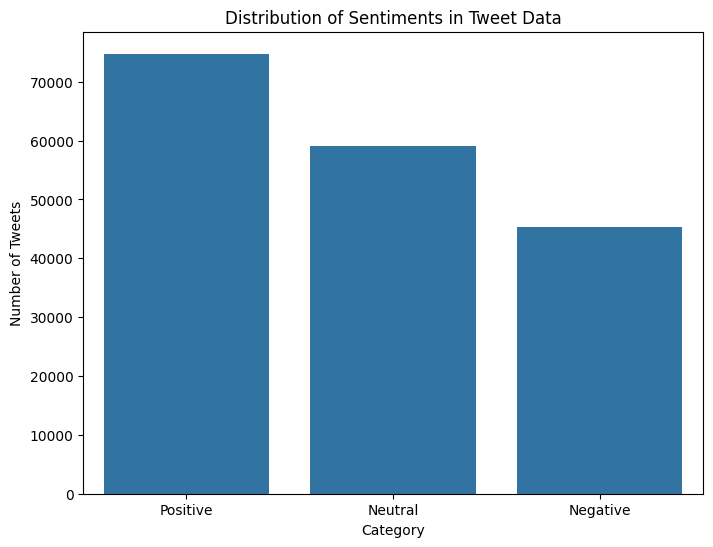

Running Preprocessing
Finished Preprocessing
Elapsed time: 151.51883602142334 seconds
['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [12]:
# Load Datasets
df = load_datasets()

# Visualize Data
visualize_Data(df)

# Preprocessing
X = preprocessing(df)

/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


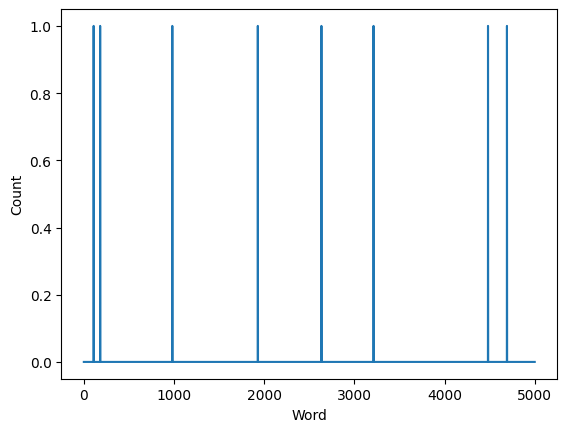

Before Tokenization & Padding 
 ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
After Tokenization & Padding 
 [   1   63  758   27 1631   27  273  920 1143   61 1273  123   28   17
   15 1047  123  250 2728 2791 1189    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [13]:
# ---Tokenizing & Padding---
# Train and test split
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed into preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size, preprocessor=lambda x: x, tokenizer=lambda x: x)

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

# Plot the BoW feature vector
plt.plot(X_train[2, :])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

print('Before Tokenization & Padding \n', X[0])
max_words = 5000
max_len = 100 # changed from 50 to 100
X, tokenizer = tokenize_pad_sequences(X, max_words, max_len)
print('After Tokenization & Padding \n', X[0])

In [14]:
# ---BuildModel---
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

vocab_size = 5000
embedding_size = 64 # changed from 32 to 64
epochs = 20
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.8

# Removed decay rate
# decay=decay_rate,
sgd = SGD(lr=learning_rate, momentum=momentum, nesterov=False)

# Build model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

tf.keras.utils.plot_model(model, show_shapes=True)

print(model.summary())

Train Set -> (107543, 100) (107543, 3)
Validation Set -> (35848, 100) (35848, 3)
Test Set -> (35848, 100) (35848, 3)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           320000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           6176      
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                  

In [15]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [16]:
 # Train model
batch_size = 64
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
1681/1681 [==============================] - 24s 14ms/step - loss: 1.0242 - accuracy: 0.4845 - precision: 0.5773 - recall: 0.1946 - val_loss: 0.9955 - val_accuracy: 0.5117 - val_precision: 0.5793 - val_recall: 0.3214
Epoch 2/20
1681/1681 [==============================] - 22s 13ms/step - loss: 0.9620 - accuracy: 0.5339 - precision: 0.6127 - recall: 0.3304 - val_loss: 0.8606 - val_accuracy: 0.5973 - val_precision: 0.6815 - val_recall: 0.4660
Epoch 3/20
1681/1681 [==============================] - 22s 13ms/step - loss: 0.7741 - accuracy: 0.6571 - precision: 0.7317 - recall: 0.5534 - val_loss: 0.6961 - val_accuracy: 0.7104 - val_precision: 0.7684 - val_recall: 0.6246
Epoch 4/20
1681/1681 [==============================] - 23s 14ms/step - loss: 0.6316 - accuracy: 0.7531 - precision: 0.7958 - recall: 0.6948 - val_loss: 0.5292 - val_accuracy: 0.8086 - val_precision: 0.8368 - val_recall: 0.7707
Epoch 5/20
1681/1681 [==============================] - 23s 14ms/step - loss: 0.5080 - a

In [17]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8340
Precision : 0.8435
Recall    : 0.8232
F1 Score  : 0.8332


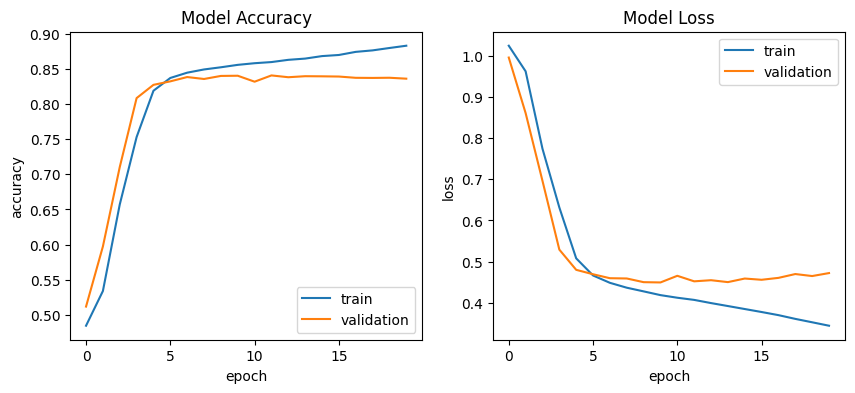

In [18]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

1121/1121 [==============================] - 4s 3ms/step


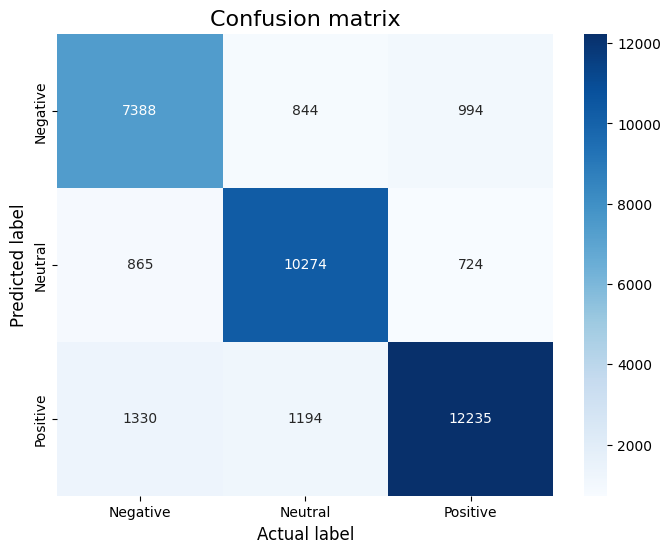

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)